In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'car', 'bird', 'cat'}
fg_used = '123'
fg1, fg2, fg3 = 1,2,3


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

{'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck'}

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

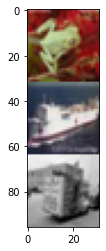

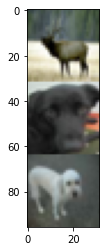

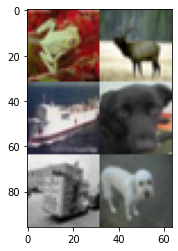

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


8


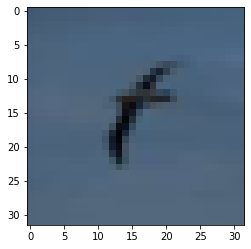

car


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [0]:
fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch163_fg_used123.pt"))

<All keys matched successfully>

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch

  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")

    optimizer.zero_grad()
    
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)


    loss = criterion(outputs, labels) 
    loss.backward()

    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 0.736
[1,    80] loss: 0.551
[1,   120] loss: 0.521
[2,    40] loss: 0.461
[2,    80] loss: 0.456
[2,   120] loss: 0.449
[3,    40] loss: 0.420
[3,    80] loss: 0.430
[3,   120] loss: 0.422
[4,    40] loss: 0.388
[4,    80] loss: 0.390
[4,   120] loss: 0.386
[5,    40] loss: 0.355
[5,    80] loss: 0.353
[5,   120] loss: 0.375
[6,    40] loss: 0.342
[6,    80] loss: 0.337
[6,   120] loss: 0.352
[7,    40] loss: 0.318
[7,    80] loss: 0.332
[7,   120] loss: 0.341
[8,    40] loss: 0.303
[8,    80] loss: 0.307
[8,   120] loss: 0.328
[9,    40] loss: 0.294
[9,    80] loss: 0.302
[9,   120] loss: 0.310
[10,    40] loss: 0.285
[10,    80] loss: 0.286
[10,   120] loss: 0.295
[11,    40] loss: 0.264
[11,    80] loss: 0.270
[11,   120] loss: 0.292
[12,    40] loss: 0.243
[12,    80] loss: 0.266
[12,   120] loss: 0.272
[13,    40] loss: 0.252
[13,    80] loss: 0.270
[13,   120] loss: 0.284
[14,    40] loss: 0.263
[14,    80] loss: 0.246
[14,   120] loss: 0.271
[15,    40] loss: 0

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [0]:
torch.argmax(alphas[5]), alphas[5]

(tensor(5, device='cuda:0', grad_fn=<NotImplemented>),
 tensor([7.3871e-05, 3.9645e-02, 5.8751e-04, 8.3415e-03, 1.3192e-01, 8.1039e-01,
         1.9251e-03, 1.7481e-04, 6.9389e-03], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)

#TRAIN SUMMARY

In [0]:
fg = [fg1, fg2, fg3]
all_list = [0,1,2,3,4,5,6,7,8,9]
bg = list(set(all_list)-set(fg))
fg, bg

([1, 2, 3], [0, 4, 5, 6, 7, 8, 9])

In [0]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table3 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

train_entry = entry

table3.append(entry)

print(tabulate(table3, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29639
total train set images 30000
focus_true_pred_true 21577 =============> FTPT : 71 %
focus_false_pred_true 8062 =============> FFPT : 26 %
focus_true_pred_false 65 =============> FTPF : 0 %
focus_false_pred_false 296 =============> FFPF : 0 %
argmax_more_than_half 23385
argmax_less_than_half 6615
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT      FTPF      FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  --------  --------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000  71.9233  26.8733  0.216667  0.986667            23385


#TEST SUMMARY

In [0]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table4 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

test_entry = entry 

table4.append(entry)

print(tabulate(table4, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 test images: 80 %
total correct 8062
total train set images 10000
focus_true_pred_true 6440 =============> FTPT : 64 %
focus_false_pred_true 1622 =============> FFPT : 16 %
focus_true_pred_false 422 =============> FTPF : 4 %
focus_false_pred_false 1516 =============> FFPF : 15 %
argmax_more_than_half 7243
argmax_less_than_half 2757
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.4   16.22    4.22   15.16             7243


#Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [0]:
from tabulate import tabulate
table1 = []
table1.append(train_entry)
entry_no = 2


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table1.append(entry)
    entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(table1, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    71.9233   26.8733    0.216667   0.986667            23385
      2  fg = 1          bg = all_except_fg                  10113    95.3822    4.00475   0.118659   0.494413             9938
      3  fg = 2          bg = all_except_fg                   9818    68.2726   30.0367    0.325932   1.36484              7346
      4  fg = 3          bg = all_except_fg                  10069    51.9217   46.7574    0.208561   1.11232              6101


In [0]:
# for testing_set
table2 = []
table2.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table2.append(entry)
    entry_no += 1

print("="*20+"Testing DATA"+"="*20)
print(tabulate(table2, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Testing DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.4       16.22      4.22       15.16               7243
      2  fg = 1          bg = all_except_fg                   3386    64.7962    16.4501    4.10514    14.6486             2452
      3  fg = 2          bg = all_except_fg                   3276    63.9194    16.4225    3.93773    15.7204             2358
      4  fg = 3          bg = all_except_fg                   3338    64.4697    15.7879    4.61354    15.1288             2433


#Set Size 1 
##3 in BG, 4 in BG, 5 in BG and so on
## On Training DATA


In [0]:
size1_table=[]
size1_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in train_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 30000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    71.9233   26.8733   0.216667    0.986667            23385
      2  fg = 1          bg = 0                               7132    95.4291    3.89792  0.140213    0.53281              7009
      3  fg = 1          bg = 4                               7239    95.3032    4.11659  0.0966984   0.483492             7112
      4  fg = 1          bg = 5                               7101    95.3387    4.01352  0.126743    0.521053             6975
      5  fg = 1          bg = 6                               7194    95.2182    4.10064  0.152905    0.528218             7049
      6  fg = 1          bg = 7                   

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [0]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  0.986667          23385
1      2          fg = 1  ...  0.532810           7009
2      3          fg = 1  ...  0.483492           7112
3      4          fg = 1  ...  0.521053           6975
4      5          fg = 1  ...  0.528218           7049

[5 rows x 9 columns]

In [0]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0 , id0)

l,u = 8,14
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1 , id1)

l,u = 15,21
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2 , id2)

71.92333333333333 26.87333333333333 0.21666666666666667 0.9866666666666668
[95.42905215928214 95.3032186766128 95.33868469229687 95.21823742007228
 95.46463245492373 95.37010976639459] ['bg = 0' 'bg = 4' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']
[68.18770692385202 68.27546463045671 67.96561604584527 67.79830969775104
 68.77527440785673 68.29689298043728] ['bg = 0' 'bg = 4' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']
[52.81102143055943 50.63361648795432 51.66526728239575 51.646495918941746
 51.52323459216621 52.4638495016145] ['bg = 0' 'bg = 4' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/train/"

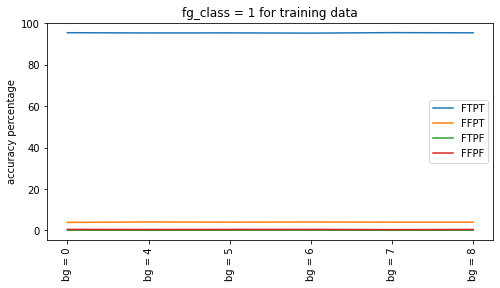

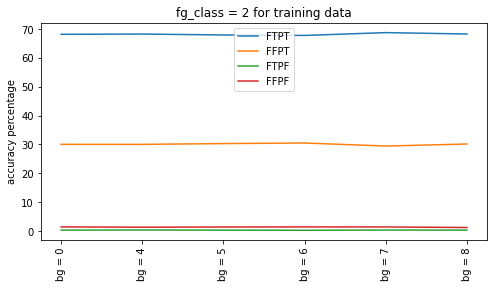

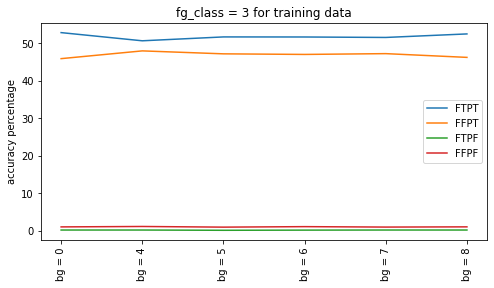

In [0]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

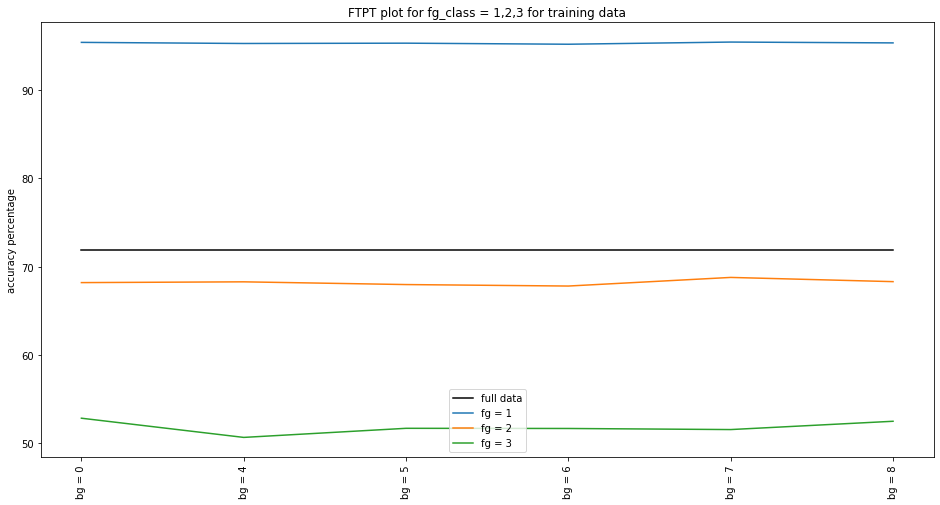

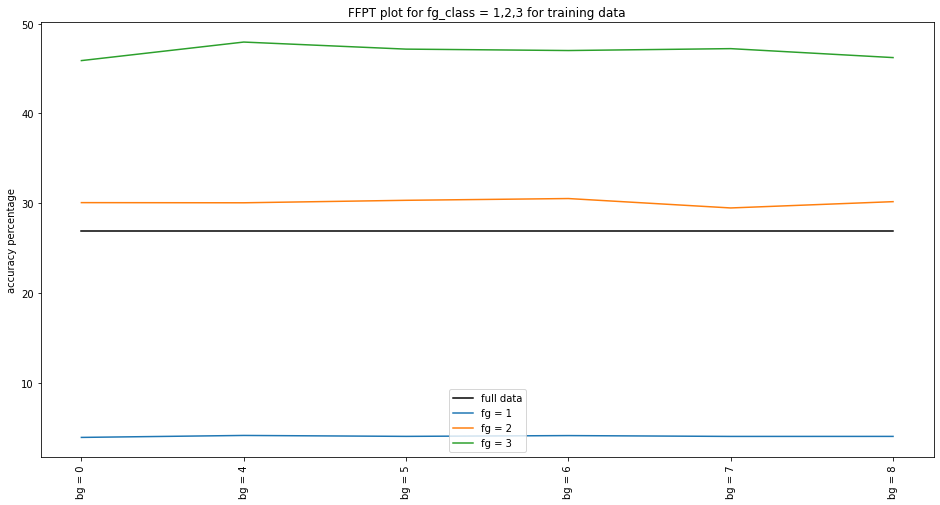

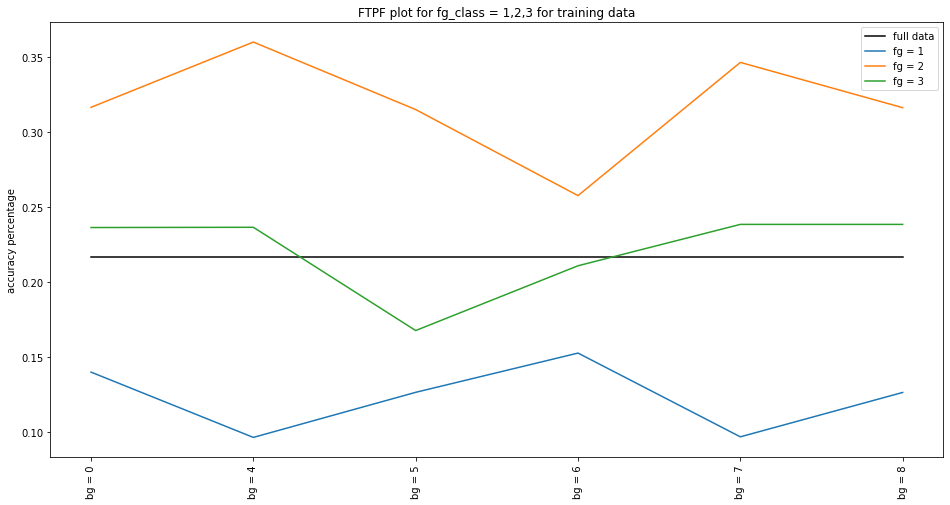

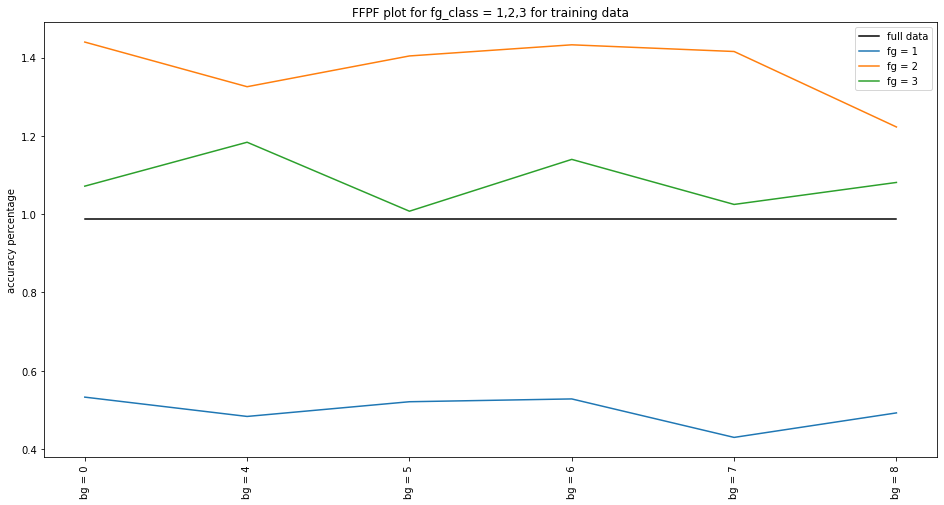

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [0]:
size1_table=[]
size1_table.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in test_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 10000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [0]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_test.csv")
test.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [0, 1, 2]  ...  7.970000           7956
1      2          fg = 0  ...  7.899160           1856
2      3          fg = 0  ...  7.401177           1826
3      4          fg = 0  ...  7.450474           1800
4      5          fg = 0  ...  7.803223           1827

[5 rows x 9 columns]

In [0]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0)

l,u = 8,14
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1)

l,u = 15,21
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2)

76.27 13.74 2.02 7.97
[76.34453781512605 75.39949537426409 76.14125753660637 75.82697201017811
 75.74468085106382 76.74620390455532]
[76.83544303797468 76.7578947368421 76.2308998302207 76.65827036104116
 76.20456466610312 75.99491955969519]
[76.33361558001694 76.9000853970965 75.8050847457627 75.57251908396947
 76.06473594548551 75.90773173857326]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/test/"

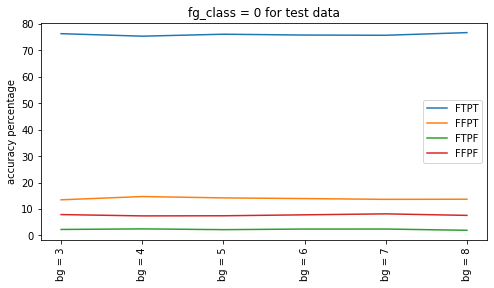

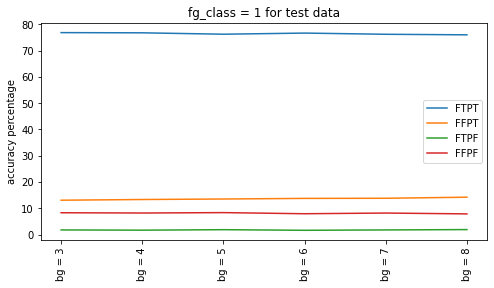

In [0]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

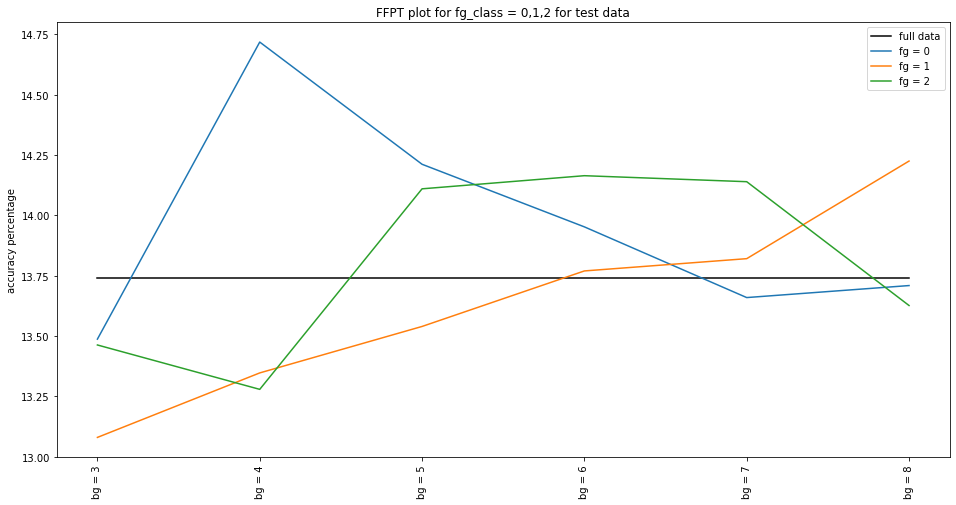

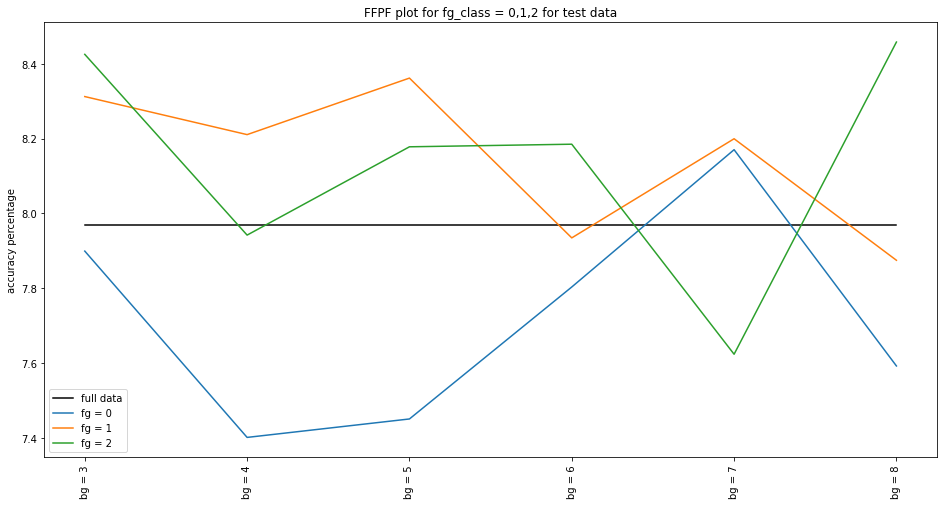

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 2 , Repetition allowed
## 33 in BG, 34 in BG, 35 in BG and so on
## On Training DATA


In [201]:
size2_table=[]
size2_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1, b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in train_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 30000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table.append(entry)
        entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size2_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    71.9233   26.8733   0.216667    0.986667            23385
      2  fg = 1          bg = 00                              7132    95.4291    3.89792  0.140213    0.53281              7009
      3  fg = 1          bg = 04                              4942    95.3055    4.02671  0.101174    0.566572             4857
      4  fg = 1          bg = 05                              4851    95.3824    3.91672  0.1443      0.556586             4770
      5  fg = 1          bg = 06                              4880    95.1025    4.09836  0.204918    0.594262             4781
      6  fg = 1          bg = 07                  

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table[i])

In [203]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  0.986667          23385
1      2          fg = 1  ...  0.532810           7009
2      3          fg = 1  ...  0.566572           4857
3      4          fg = 1  ...  0.556586           4770
4      5          fg = 1  ...  0.594262           4781

[5 rows x 9 columns]

In [204]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 50,98
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

71.92333333333333 26.87333333333333 0.21666666666666667 0.9866666666666668
[95.42905215928214 95.30554431404288 95.3823953823954 95.10245901639344]
[68.18770692385202 68.22587442056468 67.73789649415693 67.60386067981536]
[52.81102143055943 51.56375300721732 52.84355393645011 52.756227031441405]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/train/"

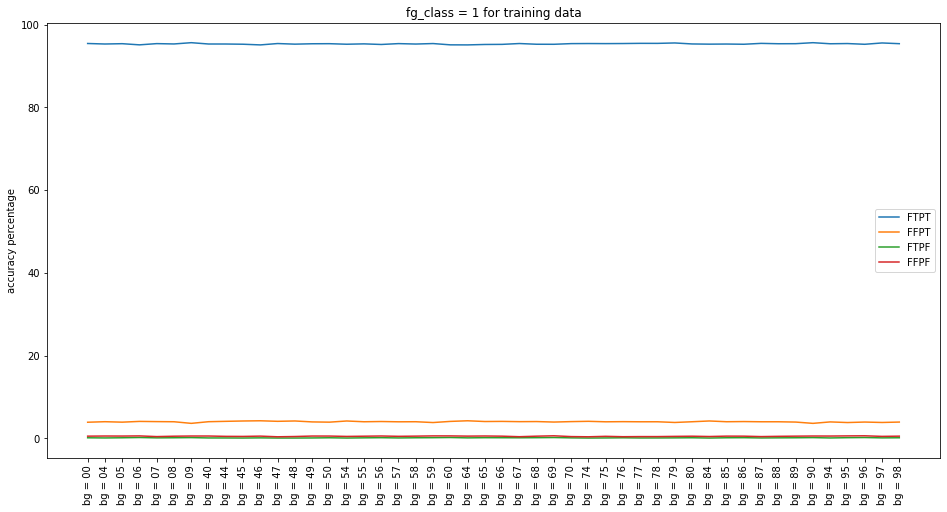

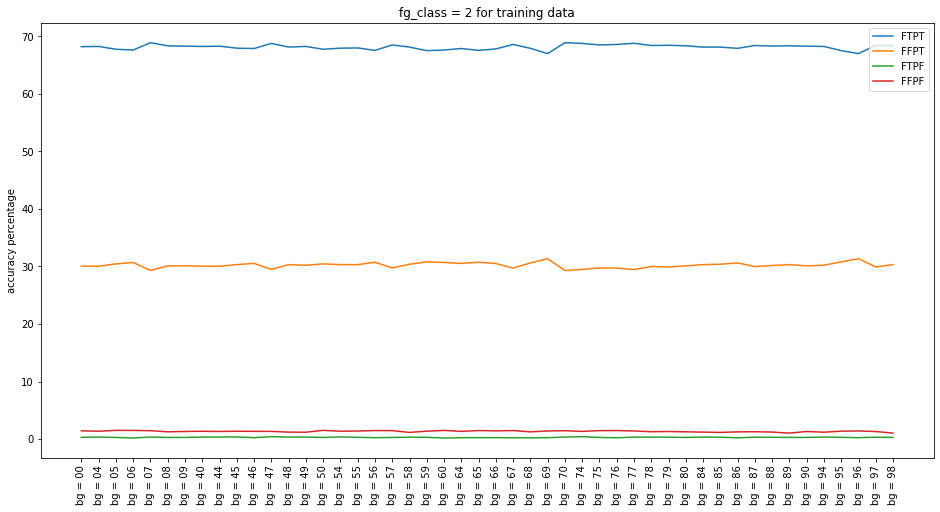

In [206]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

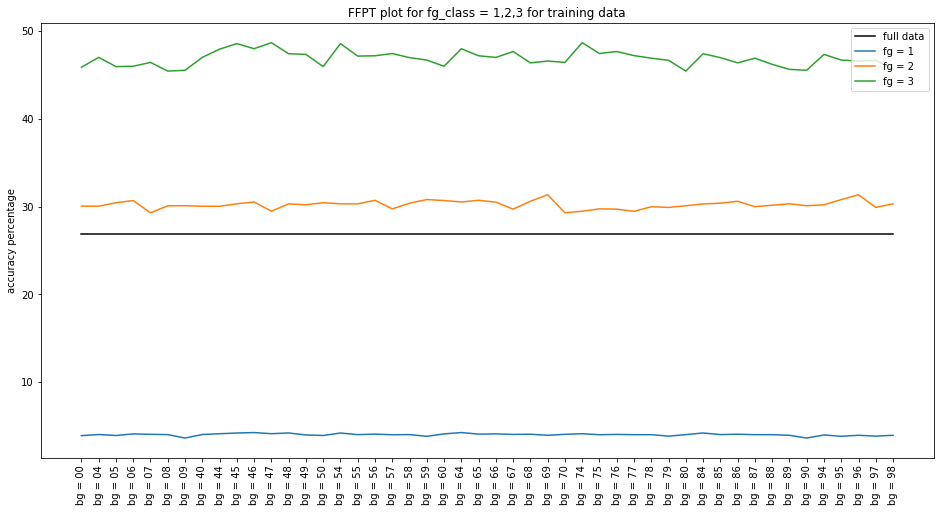

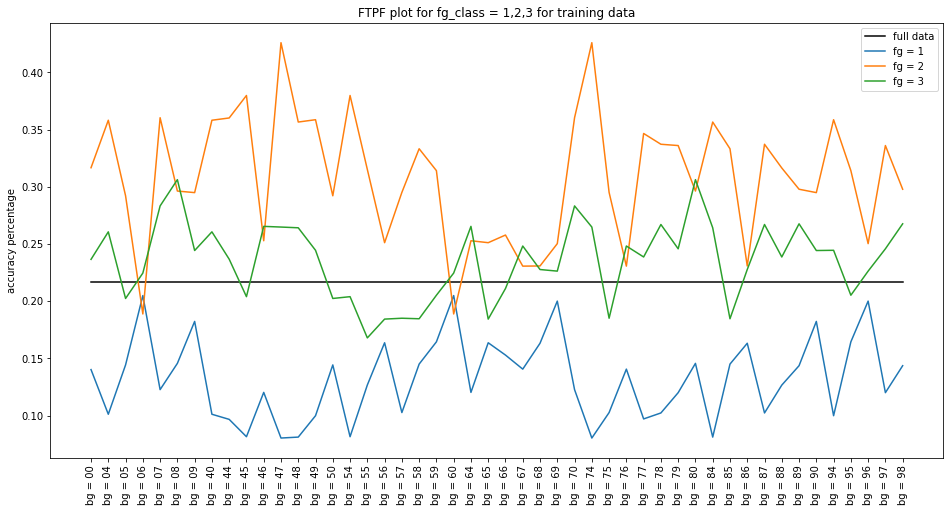

In [207]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [208]:
size2_table_test=[]
size2_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1,b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in test_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 10000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table_test.append(entry)
        entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size2_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.4       16.22      4.22       15.16               7243
      2  fg = 1          bg = 00                              2411    65.1182    16.4247    3.98175    14.4753             1758
      3  fg = 1          bg = 04                              1687    65.738     17.0124    4.03082    13.2187             1223
      4  fg = 1          bg = 05                              1638    64.3468    16.9719    3.7851     14.8962             1199
      5  fg = 1          bg = 06                              1629    65.5617    15.7152    3.99018    14.733              1204
      6  fg = 1          bg = 07                      

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table_test[i])

In [210]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  15.160000           7243
1      2          fg = 1  ...  14.475321           1758
2      3          fg = 1  ...  13.218731           1223
3      4          fg = 1  ...  14.896215           1199
4      5          fg = 1  ...  14.732965           1204

[5 rows x 9 columns]

In [211]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 50,98
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

64.4 16.22 4.22 15.16
[65.11820821236002 65.73799644339064 64.34676434676436 65.56169429097606]
[64.91901108269394 65.83850931677019 64.5 65.46031746031746]
[64.46808510638297 64.92082825822169 64.30788330229672 64.6658415841584]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/test/"

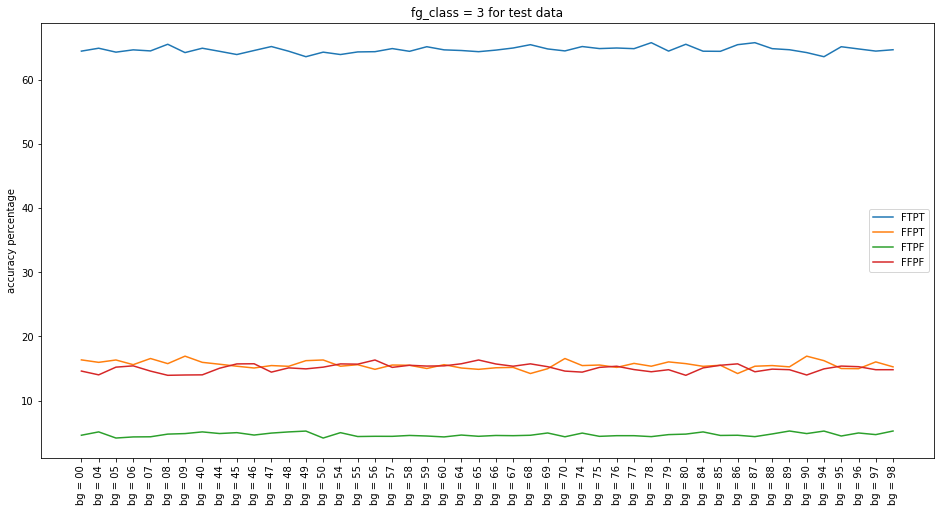

In [213]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

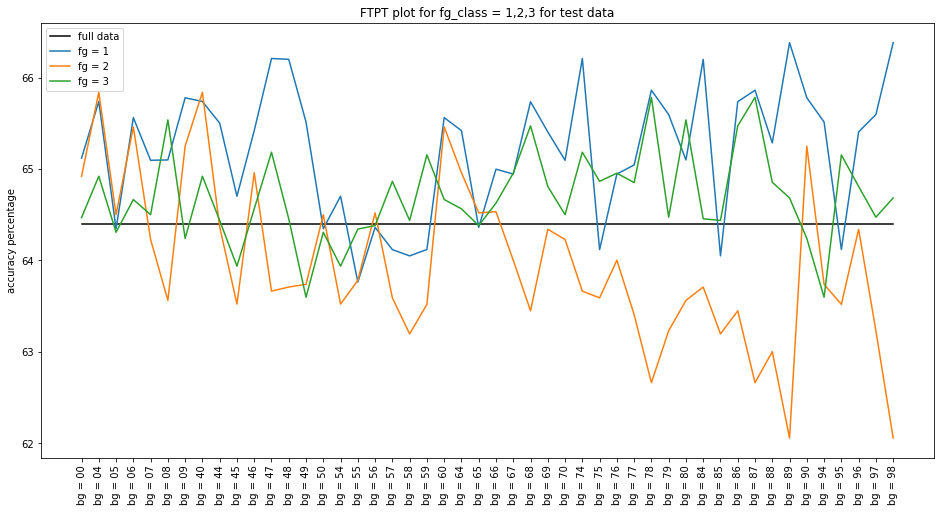

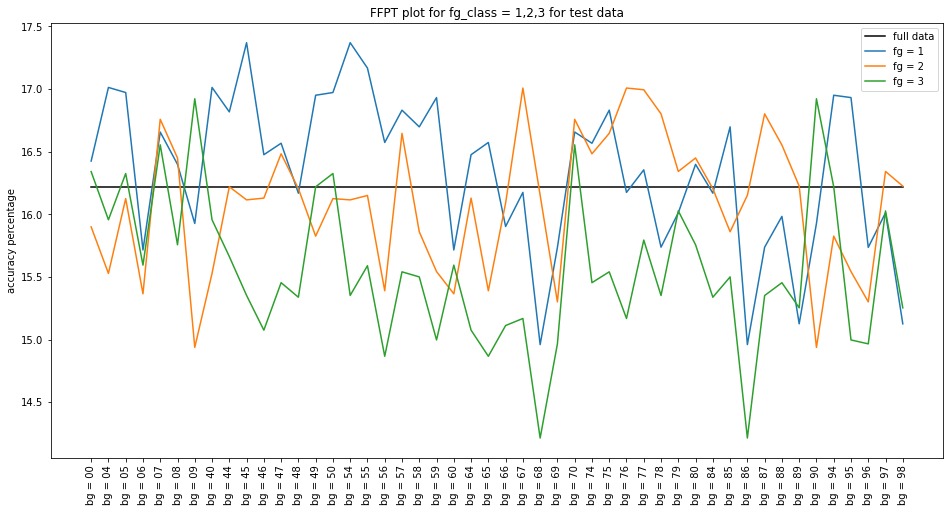

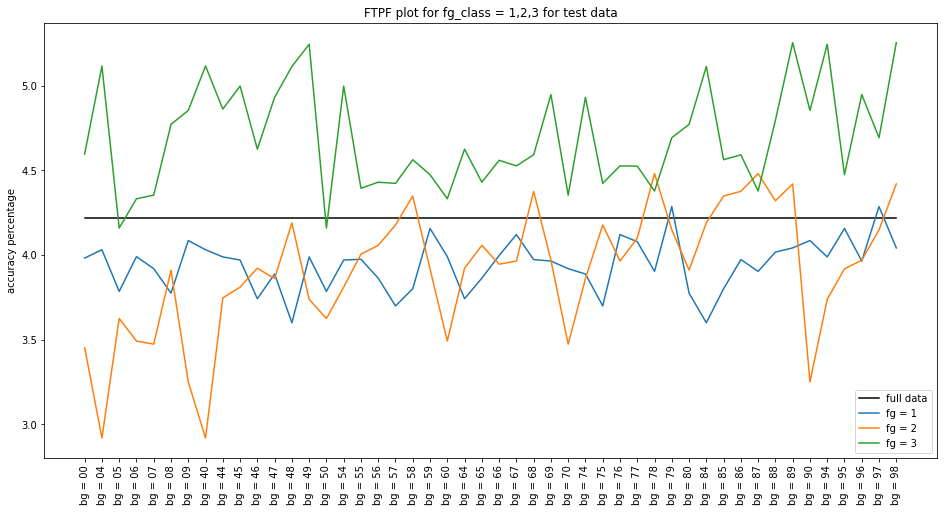

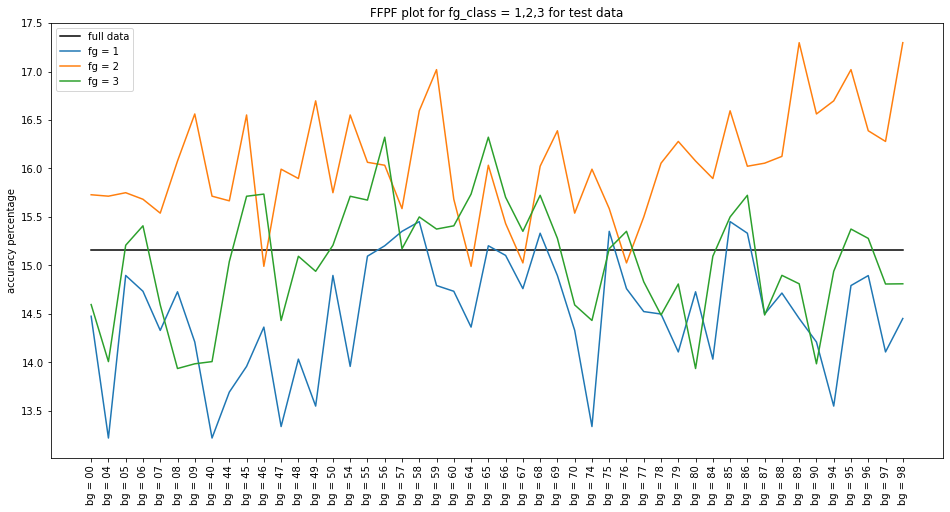

In [214]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 3 , Repetition allowed
## 333 in BG, 334 in BG, 335 in BG and so on
## On Training DATA


In [215]:
size3_table=[]
size3_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1, b2, b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s ):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2) +str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table.append(entry)
          entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size3_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    71.9233   26.8733   0.216667    0.986667            23385
      2  fg = 1          bg = 000                             7132    95.4291    3.89792  0.140213    0.53281              7009
      3  fg = 1          bg = 004                             4942    95.3055    4.02671  0.101174    0.566572             4857
      4  fg = 1          bg = 005                             4851    95.3824    3.91672  0.1443      0.556586             4770
      5  fg = 1          bg = 006                             4880    95.1025    4.09836  0.204918    0.594262             4781
      6  fg = 1          bg = 007                 

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table[i])

In [217]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  0.986667          23385
1      2          fg = 1  ...  0.532810           7009
2      3          fg = 1  ...  0.566572           4857
3      4          fg = 1  ...  0.556586           4770
4      5          fg = 1  ...  0.594262           4781

[5 rows x 9 columns]

In [218]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 344,686
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

71.92333333333333 26.87333333333333 0.21666666666666667 0.9866666666666668
[95.42905215928214 95.30554431404288 95.3823953823954 95.10245901639344]
[68.18770692385202 68.22587442056468 67.73789649415693 67.60386067981536]
[52.81102143055943 51.56375300721732 52.84355393645011 52.756227031441405]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/train/"

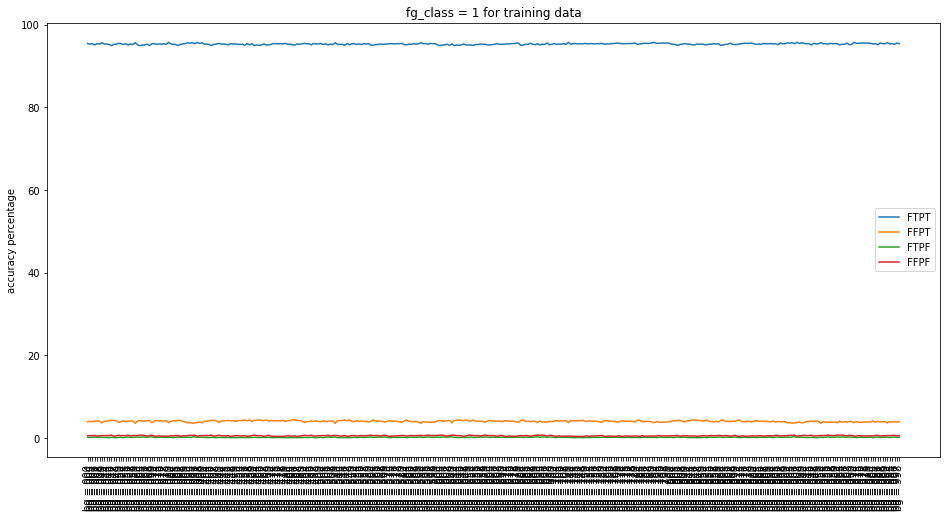

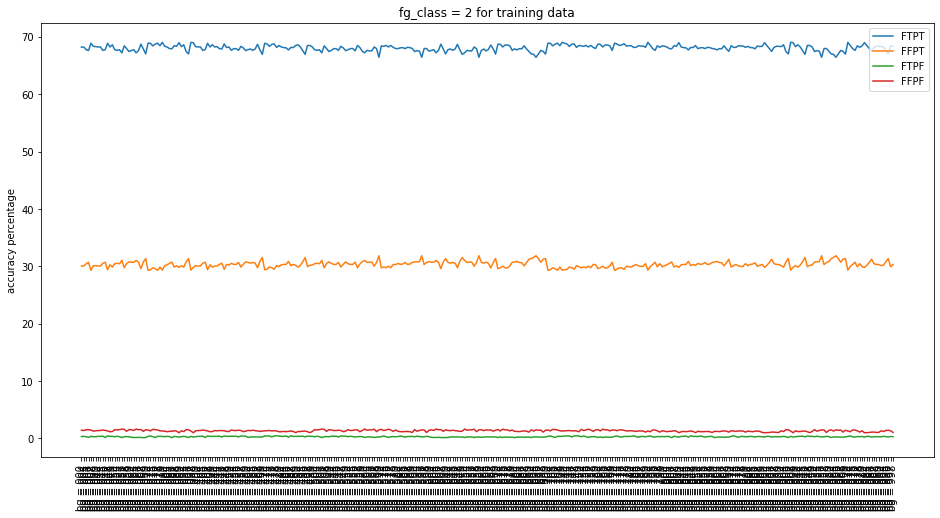

In [220]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

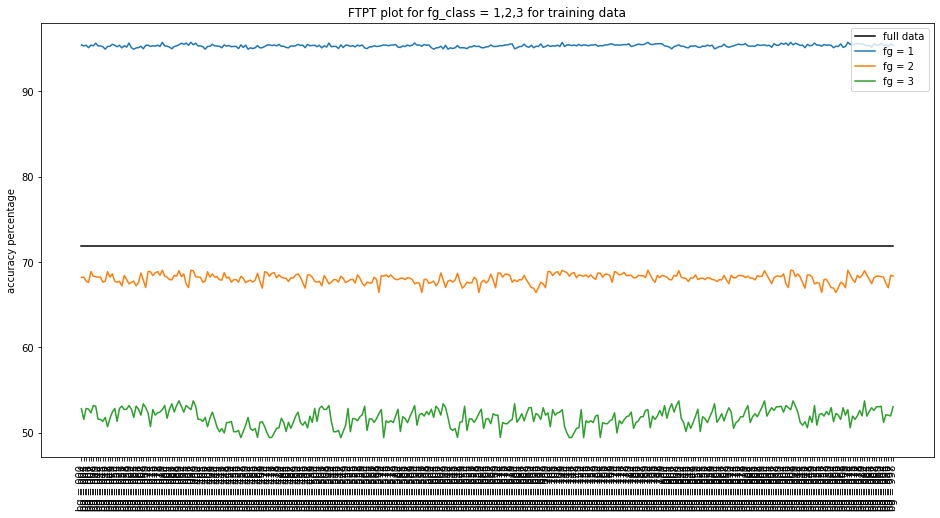

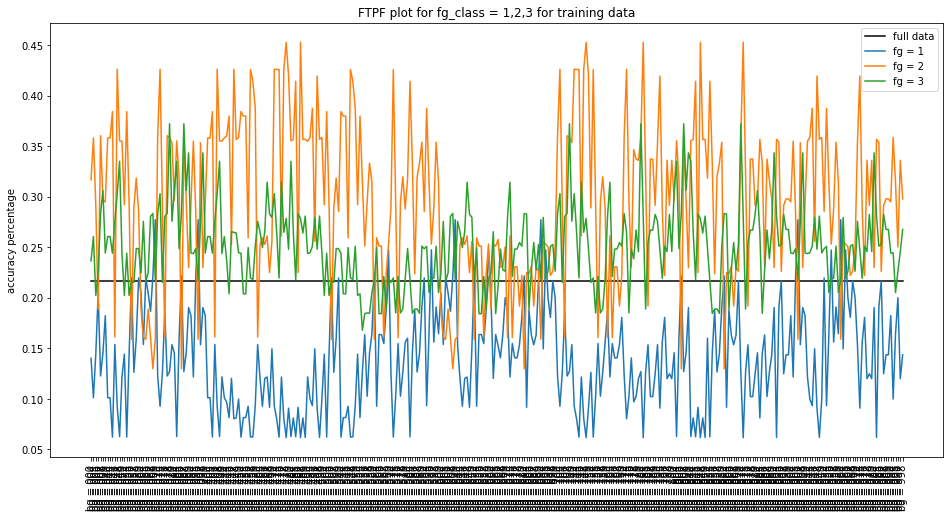

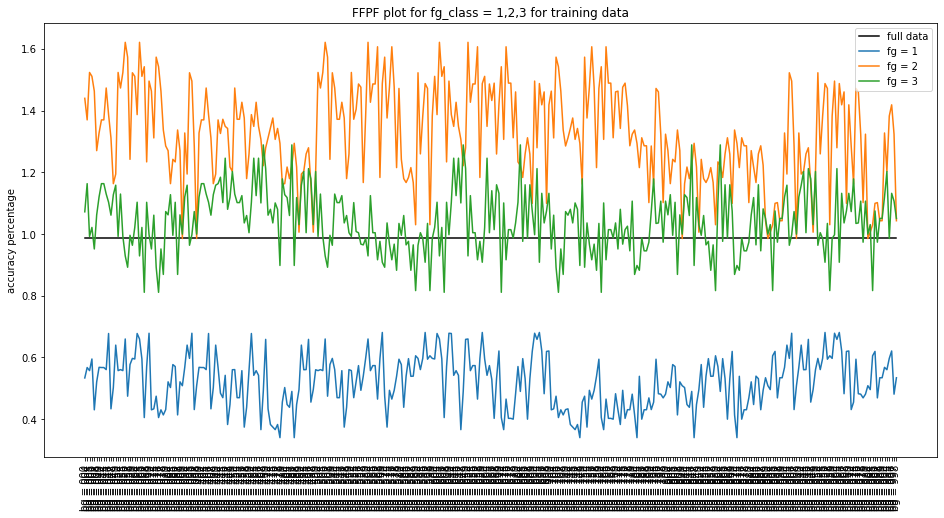

In [221]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [222]:
size3_table_test=[]
size3_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1,b2,b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2)+str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table_test.append(entry)
          entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size3_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    64.4       16.22      4.22       15.16               7243
      2  fg = 1          bg = 000                             2411    65.1182    16.4247    3.98175    14.4753             1758
      3  fg = 1          bg = 004                             1687    65.738     17.0124    4.03082    13.2187             1223
      4  fg = 1          bg = 005                             1638    64.3468    16.9719    3.7851     14.8962             1199
      5  fg = 1          bg = 006                             1629    65.5617    15.7152    3.99018    14.733              1204
      6  fg = 1          bg = 007                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table_test[i])

In [224]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [1, 2, 3]  ...  15.160000           7243
1      2          fg = 1  ...  14.475321           1758
2      3          fg = 1  ...  13.218731           1223
3      4          fg = 1  ...  14.896215           1199
4      5          fg = 1  ...  14.732965           1204

[5 rows x 9 columns]

In [225]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 344,686
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

64.4 16.22 4.22 15.16
[65.11820821236002 65.73799644339064 64.34676434676436 65.56169429097606]
[64.91901108269394 65.83850931677019 64.5 65.46031746031746]
[64.46808510638297 64.92082825822169 64.30788330229672 64.6658415841584]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/test/"

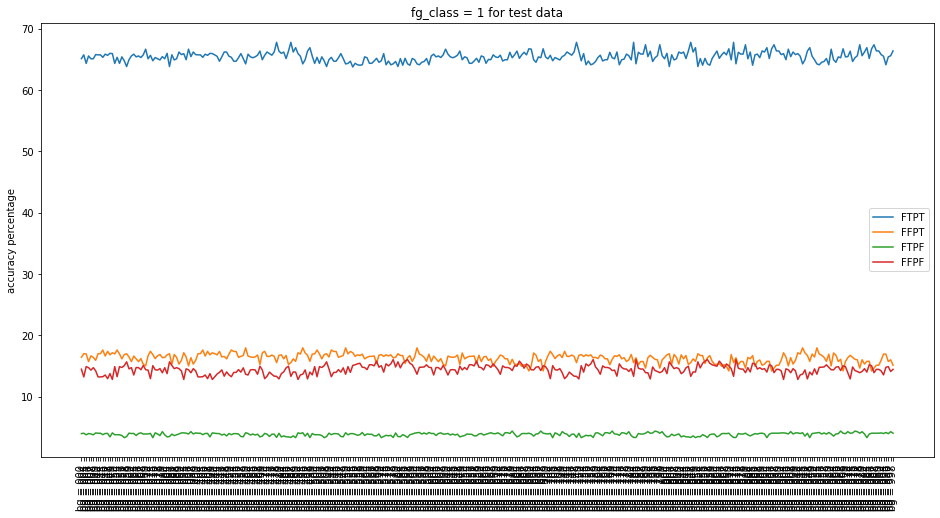

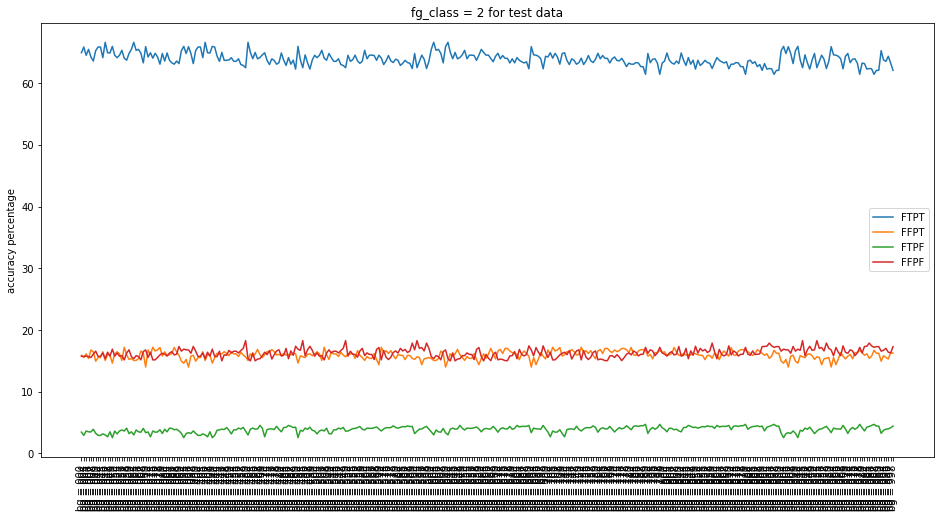

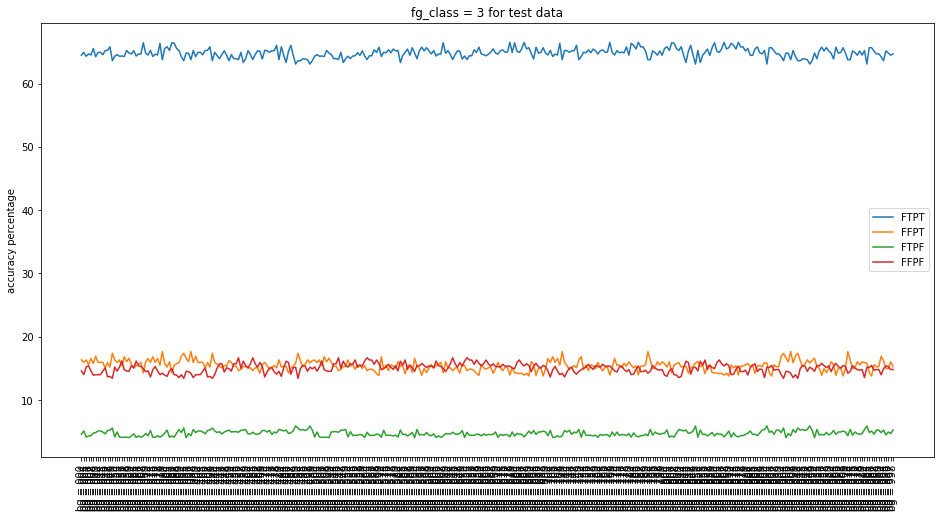

In [227]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

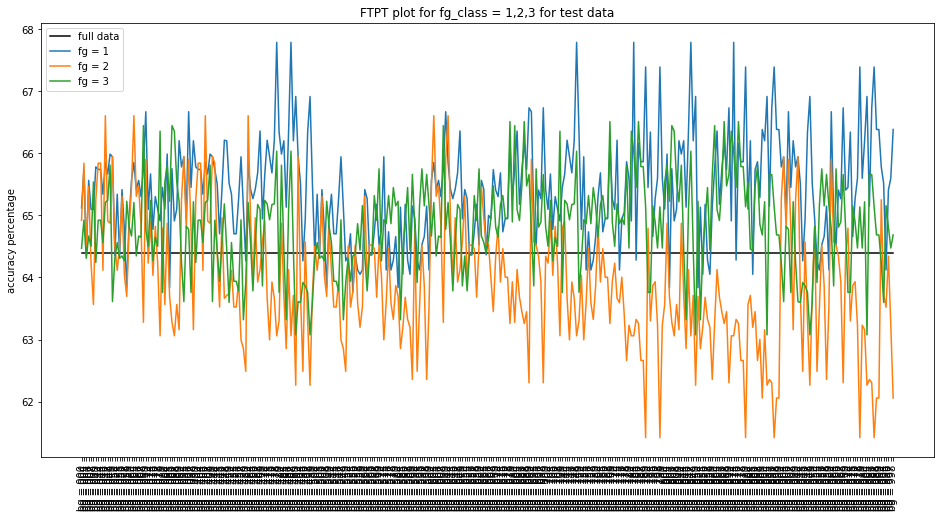

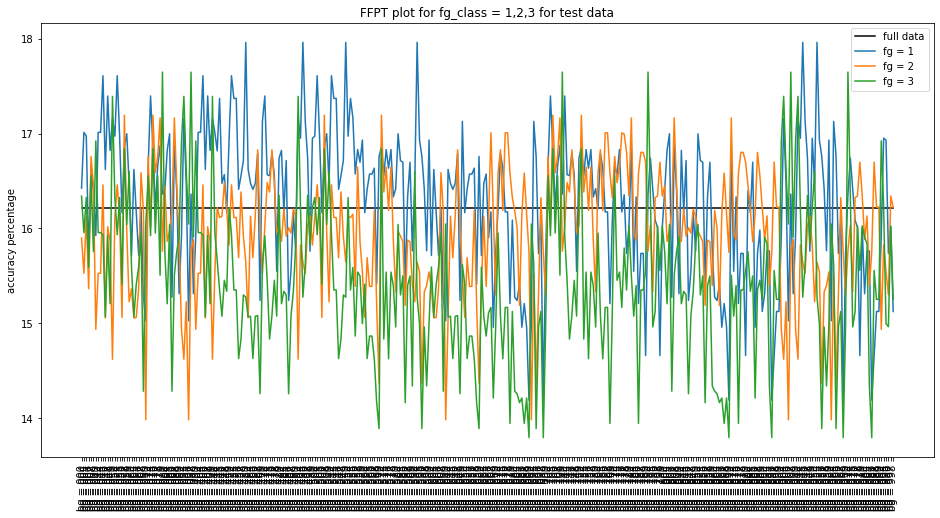

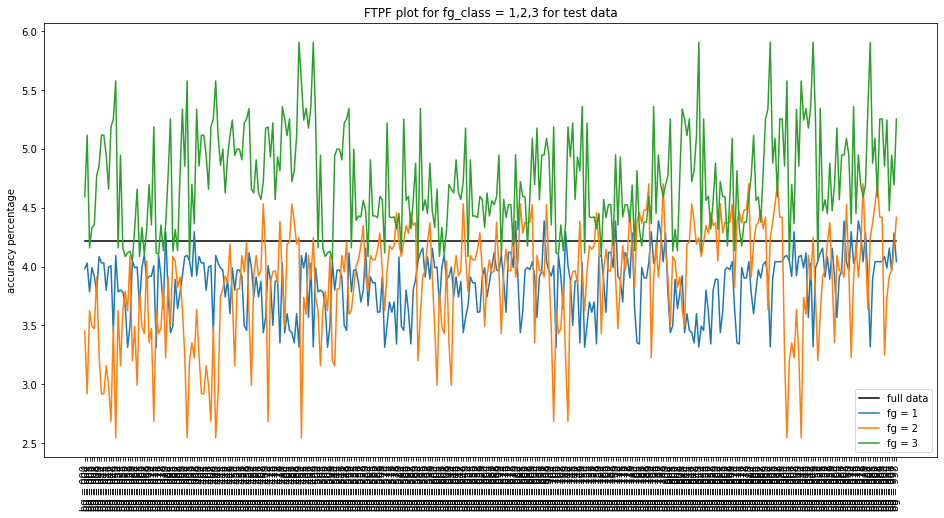

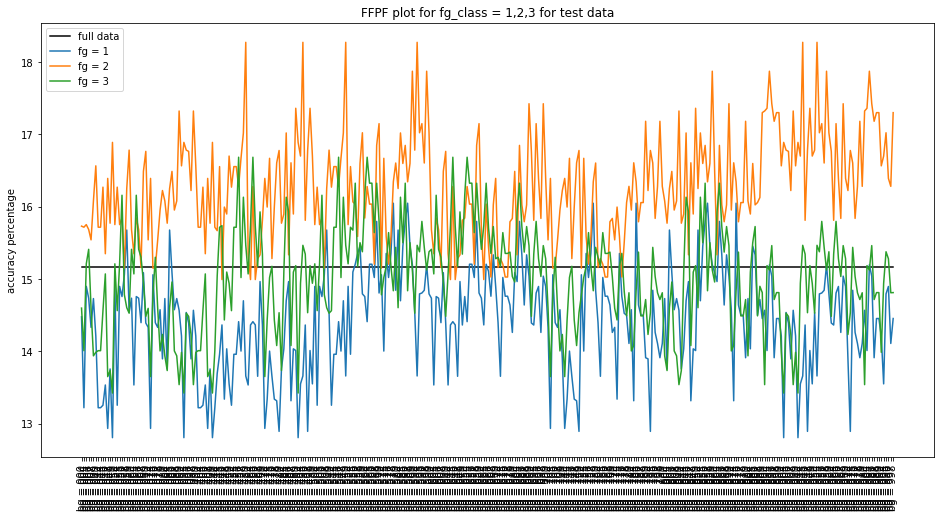

In [228]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')